In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [2]:
# Step 1: Create a directory for storing downloaded .nc files
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [3]:
# Step 2: Scrape the website for .nc file links
url = "https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/monthly/"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [4]:
# Step 3: Find all links ending with .nc
nc_links = []
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.nc'):
        nc_links.append(url + href)  # Construct the full URL

In [5]:
# Step 4: Download the .nc files into the data directory
for nc_url in nc_links:
    filename = os.path.join(data_dir, nc_url.split('/')[-1])
    
    response = requests.get(nc_url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f'Downloaded {filename}')

Downloaded data/seaice_conc_monthly_nh_197811_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197812_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197901_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197902_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197903_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197904_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197905_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197906_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197907_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197908_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197909_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197910_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197911_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197912_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_198001_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_198002_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_1

In [6]:
# Step 5: Combine the .nc files
nc_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.nc')]

# Prepare an empty list to store the modified datasets
datasets = []

# Define time points (adjust according to your actual time steps)
time_points = pd.date_range(start='1978-11-01', periods=len(nc_files), freq='MS')

# Loop through each file, open it, and assign a time coordinate
for i, nc_file in enumerate(nc_files):
    # Open the dataset
    ds = xr.open_dataset(nc_file)
    
    # Assign a time coordinate
    ds = ds.assign_coords(time=time_points[i])  # Assign the unique time coordinate
    ds = ds.expand_dims(dim='time')  # Expand to add time dimension of size 1
    
    # Append the modified dataset to the list
    datasets.append(ds)

In [14]:
# Step 6: Clean the data
# Concatenate the datasets along the time dimension
combined_ds = xr.concat(datasets, dim='time')

# Drop the 'tdim' dimension
combined_squeezed = combined_ds.squeeze('tdim')

# Replace xgrid and ygrid with lat and lon
combined_renamed = combined_squeezed.rename({'x': 'lon', 'y': 'lat'})
combined_dropped = combined_renamed.drop_vars(['xgrid', 'ygrid'], errors='ignore')
combined_gridded = combined_dropped.assign_coords(lon=np.linspace(-180, 180, 304), lat=np.linspace(31.35, 90, 448))

# Land mask the data so only values between 0 and 1 are kept (all others become nan)
combined_masked = combined_gridded.where((combined_gridded['cdr_seaice_conc_monthly'] >= 0) & (combined_gridded['cdr_seaice_conc_monthly'] <= 1))

# Get data only north of 50N
combined_north = combined_masked.where(combined_gridded['lat'] > 50, drop=True)

# Regrid the lat x lon to be lon=np.linspace(-180, 180, 1440) and lat=np.linspace(50, 90, 161)
combined_regridded = combined_north.interp(lat=np.linspace(50, 90, 161), lon=np.linspace(-180, 180, 1440))

# Rename the 'cdr_seaice_conc_monthly' variable
combined_cleaned = combined_regridded.rename({'cdr_seaice_conc_monthly': 'monthly_sic'})

# Keep only September data
september_data = combined_cleaned.where(combined_cleaned['time.month'] == 9, drop=True)

In [16]:
# Step 7: Save the combined dataset to a new .nc file
output_filename = 'NH_Sept_SIC_19792023.nc'
september_data.to_netcdf(output_filename)
print(f'Saved combined dataset to {output_filename}')

Saved combined dataset to NH_Sept_SIC_19792023.nc


In [17]:
# Step 8: Check output of combined data file
ds_test = xr.open_dataset('NH_Sept_SIC_19792023.nc')
ds_test

<xarray.Dataset> Size: 584MB
Dimensions:                                 (time: 45, lat: 161, lon: 1440)
Coordinates:
  * time                                    (time) datetime64[ns] 360B 1979-0...
  * lon                                     (lon) float64 12kB -180.0 ... 180.0
  * lat                                     (lat) float64 1kB 50.0 ... 90.0
Data variables:
    monthly_sic                             (time, lat, lon) float64 83MB ...
    melt_onset_day_cdr_seaice_conc_monthly  (time, lat, lon) float64 83MB ...
    nsidc_bt_seaice_conc_monthly            (time, lat, lon) float64 83MB ...
    nsidc_nt_seaice_conc_monthly            (time, lat, lon) float64 83MB ...
    qa_of_cdr_seaice_conc_monthly           (time, lat, lon) float64 83MB ...
    stdev_of_cdr_seaice_conc_monthly        (time, lat, lon) float64 83MB ...
    projection                              (time, lat, lon) |S8 83MB ...
Attributes: (12/41)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    ...                        ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-22T16:08:07Z
    time_coverage_start:       1987-04-01T00:00:00Z
    time_coverage_end:         1987-04-30T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...

/var/folders/qx/3x9r_17j6p953l3twnqgnk040000gn/T/ipykernel_25674/3454953680.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')


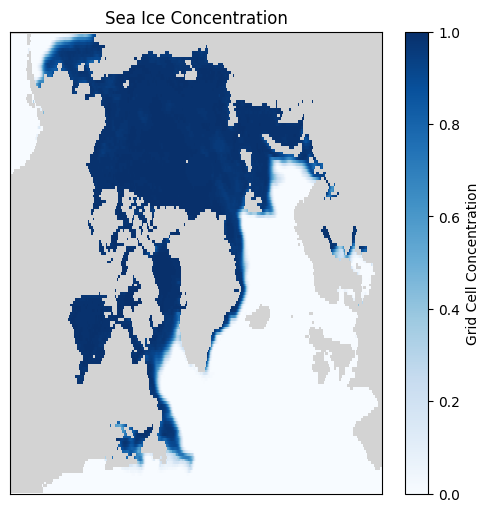

In [50]:
# Now we can analyze the data in this xarray dataset

# For example, we can calculate the mean sea ice concentration over time
# sic = ds_test['monthly_sic'].mean(dim='time')

# Or select the first month/specific month and year
sic = ds_test['monthly_sic'].isel(time=-1)

# Or Find the difference between the first and last Septembers
# sic = ds_test['monthly_sic'].isel(time=-1) - ds_test['monthly_sic'].isel(time=0)

# Get the land mask
sic_masked = sic.where(sic <= 1.0)

# Mask the NaN values
sic_masked = np.ma.masked_invalid(sic_masked)

# Define a color map
cmap = plt.cm.get_cmap('Blues')
cmap.set_bad(color='lightgrey')

# Plot the sea ice concentration
plt.figure(figsize=(6, 6))

# Add the sea ice concentration
# plt.contourf(sic_masked, levels=np.linspace(0, 1, 11), cmap=cmap, origin='upper')
plt.imshow(sic_masked, cmap=cmap, interpolation='none', aspect='auto')

# Add a colorbar
plt.colorbar(label='Grid Cell Concentration')

# Remove x and y labels
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# Add a title
plt.title('Sea Ice Concentration')

# Show the plot
plt.show()

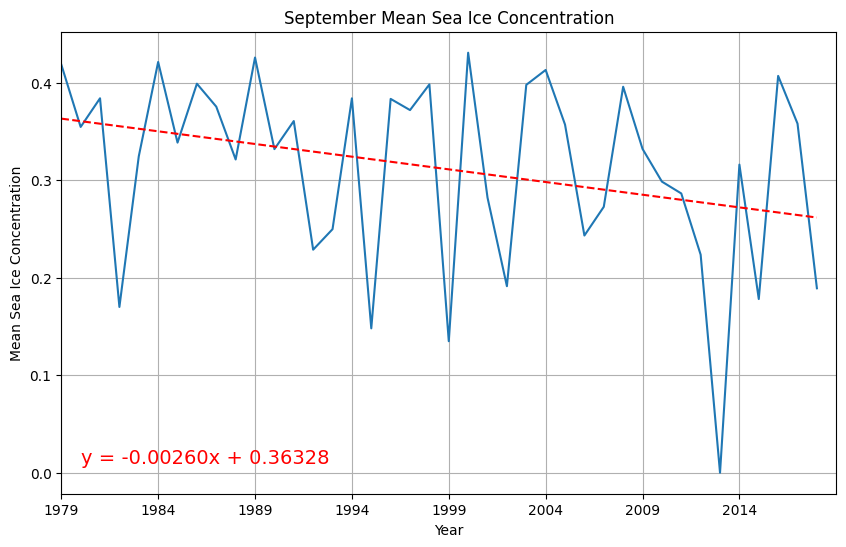

In [65]:
# We can also calculate the annual mean sea ice concentration

# Want the mean sea ice concentration where the concentration is less than or equal to 1.0
sic = np.where(sic <= 1.0, sic, np.nan)

# Reshape the first dimension
sic = sic.reshape(-1, 1440, 161)

# Take the mean of the sea ice concentration each year
annual_mean_sic = np.nanmean(sic, axis=(1, 2))

# Plot the annual mean sea ice concentration
plt.figure(figsize=(10, 6))

# Plot the annual mean sea ice concentration
plt.plot(annual_mean_sic)

# Add a linear trend
trend = np.polyfit(range(len(annual_mean_sic)), annual_mean_sic, 1)
plt.plot(np.polyval(trend, range(len(annual_mean_sic))), 'r--')

# Write the trend in the lower left corner of the plot
plt.text(1, 0.01, f'y = {trend[0]:.5f}x + {trend[1]:.5f}', color='red', fontsize=14)

# Adjust the x tick labels so they begin at 1978
plt.xticks(range(0, len(annual_mean_sic), 5), range(1979, 2024, 5)[:len(range(0, len(annual_mean_sic), 5))])

# Add a grid
plt.xlim(0, len(annual_mean_sic))
plt.grid()

# Add labels and a title
plt.xlabel('Year')
plt.ylabel('Mean Sea Ice Concentration')
plt.title('September Mean Sea Ice Concentration')

# Show the plot
plt.show()